This notebook is to download data from azure blob storage and preprocess data for the transfer learning model

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
from IPython.display import display, Image
from scipy import ndimage
from PIL import Image
from six.moves import cPickle as pickle
import random

from azure.storage.blob import BlockBlobService

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## Download Data from Azure Blob Storage

In [3]:
# Azure blob account information
ACCOUNT_NAME = "pinganhackfest2017"
ACCOUNT_KEY = "Hi7yuNxb67pBoSqwhHlnXRHnDcLyZmuVpbmc38vzA0j5HclHVIei66jIz+p7Qa9wobC8kUzBDFyI8LCe/842Ug=="

# Container name for each type of dish
CONTAINER_NAMES = ['chow-mein1', 'kung-pao1', 'roujiamo1','burger1', 'sweet-sour1']

# Image width and height
WIDTH = 128
HEIGHT = 128

In [4]:
data_root = './data/' # Change me to store data elsewhere
if not os.path.exists(data_root):
    os.makedirs(data_root)

image_dirs = CONTAINER_NAMES
for image_dir in image_dirs:
    if not os.path.exists(data_root+image_dir):
        os.makedirs(data_root+image_dir)

In [5]:
# In this example, we download the data from blob to a BytesIO object
blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

print('we are going to download the image file ...')

for container in CONTAINER_NAMES:
    generator = blob_service.list_blobs(container)
    file_num = 0
    for blob in generator:
        file_num = file_num+1
        file_path = data_root+container
        file_name = file_path+'/'+str(file_num)+'.jpg'
        try:
            blob_service.get_blob_to_path(container, blob.name, file_name)
            print('downloading successful')
        except:
            print("something wrong happened when downloading the data %s"%blob.name)

we are going to download the image file ...
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading s

downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading successful
downloading

## Resize Images

In [7]:
def get_size(root_dir, folders):
    num_images = 0
    for folder in folders:
        folder = os.path.join(root_dir, folder)
        image_files = os.listdir(folder)
        num_images += len(image_files)
    image_size = np.ndarray(shape=(num_images,2), dtype=np.integer)
    img_counter = 0
    for folder in folders:
        folder = os.path.join(root_dir, folder)
        image_files = os.listdir(folder)
        for image in image_files:
            image_file = os.path.join(folder, image)
            try:
                image_data = ndimage.imread(image_file).astype(float)
                image_size[img_counter,:] = image_data.shape[0:2]
                img_counter += 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    print("Totally %d images are scanned for sizes"%img_counter)
    avg_size = np.average(image_size, axis=0)
    print(avg_size)
    avg_size = [round(x) for x in avg_size] 
    return avg_size

def resize_image(image_file, width, height):
    try:
        pixel_depth = 255.0
        image = Image.open(image_file)
        if image.mode == 'CMYK':
            print('Converting image %s from CMYK to RGB'%image_file)
            image = image.convert('RGB')
        im2 = image.resize((width, height), Image.ANTIALIAS)
        im2 = np.array(im2.getdata(),
                    np.uint8).reshape(im2.size[1], im2.size[0], 3)
      # randomly choose some images to show both before and after resizing, to make sure that 
      # the resizing is as expected
        rn = random.random()
        if rn < 0.002:
            f, axarr = plt.subplots(1, 2)
            image_data = ndimage.imread(image_file).astype(float)
            axarr[0].imshow(image_data/255)
            axarr[1].imshow(im2/255)
    except:
        print("Resizing failed on file %s"%image_file)
    return im2

def load_resize_images(root_dir, folder, width, height):
    """Load and resize the images."""
    pixel_depth = 255.0
    folder = os.path.join(root_dir, folder)
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), height, width, 3),
                         dtype=np.float16)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        filename, file_extension = os.path.splitext(image_file)
        if file_extension in [".jpg", ".JPG", ".jpeg"]:
            try:
                image_data = (np.array(Image.open(image_file)).astype(float) - 
                            pixel_depth / 2) / pixel_depth
                if len(image_data.shape) == 3:
                    if image_data.shape[2] < 3:
                        print("Image file %s has %d channels, skipping"%(image_file, image_data.shape[2]))
                    elif image_data.shape[0] < width or image_data.shape[1] < height:
                        print("Image file %s is too small, skipping"%image_file)
                    else:
                        try:
                            image_data = resize_image(image_file, width, height)
                            dataset[num_images, :, :, :] = image_data
                            num_images = num_images + 1
                        except:
                            print("Could not resize %s, skipping"%image_file)
                else:
                    print("Image file %s only has %d dimensions, skipping"%(image_file, len(image_data.shape)))
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        else:
            print("Image file %s is not a jpg file, skipping"%image_file)
            
    dataset = dataset[0:num_images, :, :, :]
    print("%d images in folder %s are added into the pickle file"%(num_images, folder))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(root_dir, image_folders, width, height, force=False):
    dataset_names = []
    for folder in image_folders:
        set_filename = folder + '.pickle'
        set_filename = os.path.join(root_dir, set_filename)
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_resize_images(root_dir, folder, width, height)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names

Pickling ./blob_data3/chow-mein1.pickle.
./blob_data3/chow-mein1
100 images in folder ./blob_data3/chow-mein1 are added into the pickle file
Full dataset tensor: (100, 128, 128, 3)
Mean: 128.13
Standard deviation: inf
Pickling ./blob_data3/kung-pao1.pickle.
./blob_data3/kung-pao1
Resizing failed on file ./blob_data3/kung-pao1\98.jpg
Could not resize ./blob_data3/kung-pao1\98.jpg, skipping
99 images in folder ./blob_data3/kung-pao1 are added into the pickle file
Full dataset tensor: (99, 128, 128, 3)
Mean: 135.75
Standard deviation: inf
Pickling ./blob_data3/roujiamo1.pickle.
./blob_data3/roujiamo1
100 images in folder ./blob_data3/roujiamo1 are added into the pickle file
Full dataset tensor: (100, 128, 128, 3)
Mean: 134.63
Standard deviation: inf
Pickling ./blob_data3/burger1.pickle.
./blob_data3/burger1
Could not read: ./blob_data3/burger1\77.jpg : cannot identify image file './blob_data3/burger1\\77.jpg' - it's ok, skipping.
Resizing failed on file ./blob_data3/burger1\81.jpg
Could n

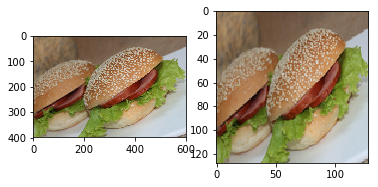

In [8]:
# Set the width and height of the images and store the image data in a pickle file
dataset_names = maybe_pickle(data_root, image_dirs, WIDTH, HEIGHT)

In [10]:
def make_arrays(nb_rows, width, height):
    if nb_rows:
        dataset = np.ndarray((nb_rows, width, height, 3), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, width, height, train_ratio = 0.8, validation_ratio = 0.2):
    num_classes = len(pickle_files)
    num_datasets = [0]*num_classes
    for i in range(num_classes):
        with open(pickle_files[i], 'rb') as f:
            load_data = pickle.load(f)
            num_datasets[i] = load_data.shape[0]
            
    total_datasets = np.sum(num_datasets)
    
    num_train = [int(round(float(x)*train_ratio)) for x in num_datasets]
    num_valid = [int(round(float(x)*validation_ratio)) for x in num_datasets]
    
    total_train = np.sum(num_train)
    total_valid = np.sum(num_valid)
   
    print("There are %d, %d train and validation images."%(total_train, total_valid))
    train_dataset, train_labels = make_arrays(total_train, width, height)
    valid_dataset, valid_labels = make_arrays(total_valid, width, height)
  
    start_v, start_trn = 0, 0
    for label, pickle_file in enumerate(pickle_files): # the first element in pickle_files will be label 0, 
                                                     # the second with label 1      
        try:
            with open(pickle_file, 'rb') as f:
                data_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(data_set)
                train_data = data_set[0:num_train[label], :, :, :]
                train_dataset[start_trn:(start_trn+num_train[label]), :, :, :] = train_data
                train_labels[start_trn:(start_trn+num_train[label])] = label
                start_trn += num_train[label]

                valid_data = data_set[num_train[label]:(num_valid[label]+num_train[label]), :, :, :]
                valid_dataset[start_v:(start_v+num_valid[label]), :, :, :] = valid_data
                valid_labels[start_v:(start_v+num_valid[label])] = label
                start_v += num_valid[label]

        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise   
    return train_dataset, train_labels, valid_dataset, valid_labels
            
            
train_dataset, train_labels, valid_dataset, valid_labels = merge_datasets(dataset_names, height, width)
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)

There are 395, 99 train and validation images.
Training: (395, 128, 128, 3) (395,)
Validation: (99, 128, 128, 3) (99,)


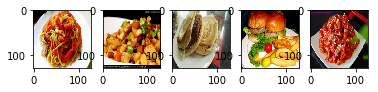

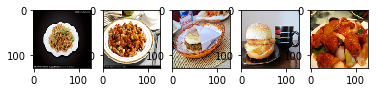

In [11]:
# Visualize each classes of images in the dataset
def visualize_each_class_images(dataset, labels):
    unique_labels = set(labels)
    num_labels = len(unique_labels)
    f, axarr = plt.subplots(1, num_labels)
    for label in unique_labels:
        image_index = list(np.where(labels ==label)[0])[0]# the first image of each type of label
        image_data = dataset[image_index,:,:,:]
        image_data = image_data/255
        axarr[label].imshow(image_data, interpolation='none')
    
visualize_each_class_images(train_dataset, train_labels)
visualize_each_class_images(valid_dataset, valid_labels)


In [12]:
# Store the training and validation data in a pickle file
pickle_file = os.path.join(data_root, 'data.pickle')
try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise